### Preparation

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

df = pd.read_parquet("../../data/de_train.parquet")
selected_mol = Chem.MolFromSmiles(df.loc[3, "SMILES"])

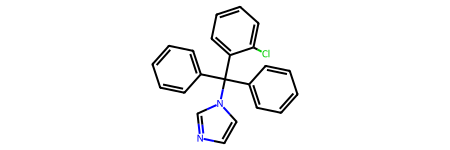

In [2]:
selected_mol

### Exporing One Molecule

#### Featurizing Mol, Atom and Bond Objects

In [3]:
def featurize_mol(mol):
    # TODO: Substruct Match

    features = {
        "num_arom_atoms": len(mol.GetAromaticAtoms()),
        "num_atoms": mol.GetNumAtoms(), # Note: GetAtoms to get list of atom objects
        "num_heavy_atoms": mol.GetNumHeavyAtoms(),
        "num_rings": mol.GetRingInfo().NumRings(), # TODO: Explore RingInfo class
        "num_bonds": mol.GetNumBonds(),
    }
    return features

featurize_mol(selected_mol)

{'num_arom_atoms': 23,
 'num_atoms': 25,
 'num_heavy_atoms': 25,
 'num_rings': 4,
 'num_bonds': 28}

In [4]:
def featurize_atom(atom):
    features = {
        "atomic_num": atom.GetAtomicNum(),
        "degree": atom.GetDegree(),
        "form_charge": atom.GetFormalCharge(),
        "hybridization": str(atom.GetHybridization()), # Needs further encoding
        "is_aromatic": atom.GetIsAromatic(),
        "mass": atom.GetMass(),
        "in_ring": atom.IsInRing(), # Can also use IsInRingSize(size)
        "implicit_hs": atom.GetImplicitValence(),
    }
    return features

selected_atom = selected_mol.GetAtomWithIdx(2)
featurize_atom(selected_atom)

{'atomic_num': 6,
 'degree': 2,
 'form_charge': 0,
 'hybridization': 'SP2',
 'is_aromatic': True,
 'mass': 12.011,
 'in_ring': True,
 'implicit_hs': 1}

In [5]:
def featurize_bond(bond):
    features = {
        "bond_type": str(bond.GetBondType()), # Needs more encoding later on
        "is_aromatic": bond.GetIsAromatic(),
        "is_conjugated": bond.GetIsConjugated(),
        "atom1": bond.GetBeginAtom().GetSymbol(),
        "atom2": bond.GetOtherAtom(bond.GetBeginAtom()).GetSymbol() # See?
    }
    return features

selected_bond = selected_mol.GetBondWithIdx(2)
featurize_bond(selected_bond)

{'bond_type': 'AROMATIC',
 'is_aromatic': True,
 'is_conjugated': True,
 'atom1': 'C',
 'atom2': 'C'}

#### Computations + Atom Notes

In [6]:
from rdkit.Chem import AllChem

selected_mol = Chem.MolFromSmiles(df.loc[3, "SMILES"])

print("before calc:")
print(selected_mol.GetAtoms()[0].GetPropsAsDict().keys())

print("after calc:")
AllChem.ComputeGasteigerCharges(selected_mol)
print(selected_mol.GetAtoms()[0].GetPropsAsDict().keys())

before calc:
dict_keys(['__computedProps', '_CIPRank'])
after calc:
dict_keys(['__computedProps', '_CIPRank', '_GasteigerCharge', '_GasteigerHCharge'])


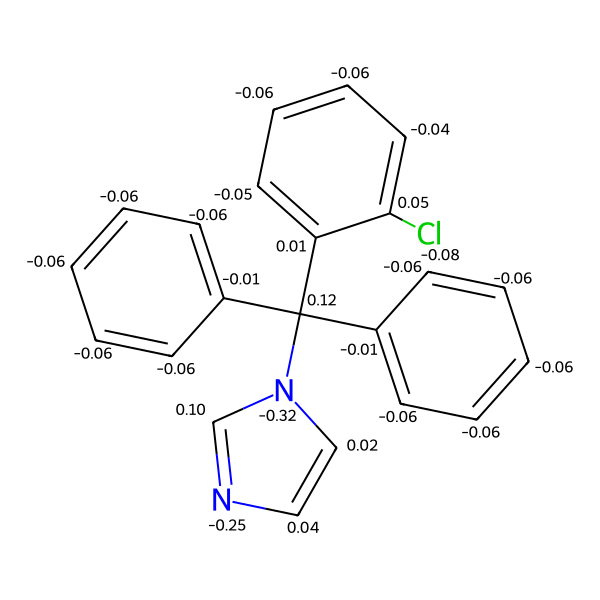

In [7]:
for atom in selected_mol.GetAtoms():
    atom.SetProp("atomNote", f"{float(atom.GetProp('_GasteigerCharge')):.2f}")

IPythonConsole.molSize = (600, 600)
selected_mol

In [8]:
IPythonConsole.molSize = (250, 250)

### Substructure Search

**SMARTS** <br> 
https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
- Bonds: -(single), =(double), #(triple), :(arom), ~(any), @(any ring bond)
- Atoms --> Symbol or AtomNum
    - [c] (Arom C), [C] (Aliph C), [#6] or [C,c] (any C)
    - [A] or [a] or [*] --> any atom (aliph, arom, any)
    - [R] (any ring), [R3] in a 3 atom ring
    - Implicit Hs --> [NH2] for amine group
    - Charge --> [nH+] (protonated aromatic nitrogen) or [++] (atom with 2+ charge)
    - Connectivity --> X for explicit and D for exp+imp --> [CX4] or [D3]
- Recursive...



#### In Single Mol

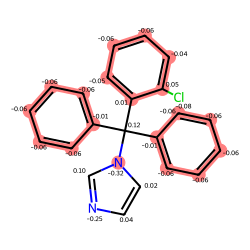

In [9]:
selected_mol.GetSubstructMatches(query=Chem.MolFromSmarts("cccccc"))
selected_mol.__sssAtoms.append(20) # To manually set where should be highlighted!
selected_mol

#### In Multiple Mols

In [10]:
def find_mols(mol_list, substructure):
    mols_out = []
    for mol in mol_list:
        if mol.HasSubstructMatch(query=Chem.MolFromSmarts(substructure)):
            mols_out.append(mol)
    return mols_out

selected_mols = [Chem.MolFromSmiles(x) for x in set(df.loc[3:90, "SMILES"].to_list())]
print("before filter:", len(selected_mols))
filtered_mols = find_mols(selected_mols, "cccccc")
print("after filter:", len(filtered_mols))

before filter: 22
after filter: 19
